In [1]:
# 📌 1. Importar Librerías
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

In [2]:
# 📌 2. Cargar Municipios y Convertir a WGS 84
municipios_gdf = gpd.read_file("municipios.shp")
municipios_gdf = municipios_gdf.to_crs(epsg=4326)  # Asegurar CRS correcto

In [3]:
# 📌 3. Cargar Datos de Población y Unir con Municipios
poblacion_df = pd.read_csv("poblacion.csv")
municipios_gdf = municipios_gdf.merge(poblacion_df, left_on="nombre", right_on="municipio", how="left")

In [4]:
# 📌 4. Clasificación de Municipios por Tamaño Poblacional
def clasificar_municipio(poblacion):
    if poblacion < 10000:
        return "pequeño"
    elif 10000 <= poblacion < 50000:
        return "mediano"
    else:
        return "grande"

municipios_gdf["categoria"] = municipios_gdf["poblacion"].apply(clasificar_municipio)

In [5]:
# 📌 5. Asignación de Tiempos de Viaje  según el tamaño del municipio y el tipo de servicio cultural: museos y bibliotecas.

tiempos_viaje = {
    "pequeño": {"bibliotecas": 10, "museos": 15},
    "mediano": {"bibliotecas": 15, "museos": 20},
    "grande": {"bibliotecas": 20, "museos": 25}
}

def asignar_tiempo_viaje(row, tipo):
    return tiempos_viaje[row["categoria"]][tipo]

municipios_gdf["tiempo_bibliotecas"] = municipios_gdf.apply(lambda row: asignar_tiempo_viaje(row, "bibliotecas"), axis=1)
municipios_gdf["tiempo_museos"] = municipios_gdf.apply(lambda row: asignar_tiempo_viaje(row, "museos"), axis=1)

In [6]:
# 📌 6. Cálculo de Centroides de los NUCLEOS URBANOS (Transformación Correcta de CRS)
# 📌 Cargar Núcleos de Población y Convertir a WGS 84
nucleos_gdf = gpd.read_file("nucleos.shp").to_crs(epsg=4326)  # Asegurar CRS correcto

# 📌 Convertir a CRS proyectado (metros) para cálculo de centroides
nucleos_proj = nucleos_gdf.to_crs(epsg=3857)

# 📌 Calcular centroides
nucleos_proj["centroide"] = nucleos_proj.geometry.centroid

# 📌 Volver a WGS 84 con los centroides
nucleos_proj = nucleos_proj.set_geometry("centroide").to_crs(epsg=4326)

# 📌 Crear el GeoDataFrame de centroides basado en los núcleos urbanos
centroides_gdf = gpd.GeoDataFrame(
    nucleos_proj[["nombre", "centroide"]],
    geometry="centroide",
    crs="EPSG:4326"
)

# 📌 Verificar la estructura
print(centroides_gdf.head())


                       nombre                 centroide
0                     Sevilla  POINT (-5.95927 37.3897)
1                       Camas  POINT (-6.03425 37.3999)
2  Valencina de la Concepción  POINT (-6.0754 37.41508)


In [7]:
# 📌 7. Cargar Equipamientos Culturales (Bibliotecas y Museos) y Asegurar WGS 84
bibliotecas_gdf = gpd.read_file("bibliotecas.shp").to_crs(epsg=4326)
museos_gdf = gpd.read_file("museos.shp").to_crs(epsg=4326)

In [8]:
# 📌 8. Filtrar Equipamientos que Están Dentro de los Municipios
bibliotecas_gdf = bibliotecas_gdf[bibliotecas_gdf.geometry.apply(lambda x: any(x.within(m) for m in municipios_gdf.geometry))]
museos_gdf = museos_gdf[museos_gdf.geometry.apply(lambda x: any(x.within(m) for m in municipios_gdf.geometry))]

In [9]:
# 📌 9. Generar Isócronas con OpenRouteService
import requests

# 📌 Tu clave de API de OpenRouteService
API_KEY = "5b3ce3597851110001cf62488feab9edfc2445428dc5cfaf247a6357"

def obtener_isocrona(lat, lon, tiempo):
    url = "https://api.openrouteservice.org/v2/isochrones/foot-walking"
    headers = {"Authorization": API_KEY}  # 🔹 Clave en headers
    params = {
        "locations": [[lon, lat]],  # Longitud primero, luego latitud
        "range": [tiempo * 60],  # Tiempo en segundos
        "range_type": "time",
        "units": "m"
    }
    
    response = requests.post(url, headers=headers, json=params)  # 🔹 Añadimos headers
    
    if response.status_code == 200:
        data = response.json()
        return data["features"][0]["geometry"]  # Extraer la geometría
    else:
        print("Error:", response.json())  # Mostrar error exacto
        return None


In [10]:
# 📌 1️⃣ Verificar que centroides_gdf ya existe y tiene los centroides
print("Columnas antes del merge:", centroides_gdf.columns)

# 📌 2️⃣ Eliminar columnas duplicadas antes del merge (por si acaso)
columnas_a_eliminar = ["tiempo_bibliotecas", "tiempo_museos"]
centroides_gdf = centroides_gdf.drop(columns=[col for col in columnas_a_eliminar if col in centroides_gdf.columns], errors="ignore")

# 📌 3️⃣ Hacer el merge con municipios_gdf para traer los tiempos de viaje
centroides_gdf = centroides_gdf.merge(
    municipios_gdf[["nombre", "tiempo_bibliotecas", "tiempo_museos"]],
    on="nombre",
    how="left"
)

# 📌 4️⃣ Verificar si las columnas se añadieron correctamente
print(centroides_gdf[["nombre", "tiempo_bibliotecas", "tiempo_museos"]].head())

Columnas antes del merge: Index(['nombre', 'centroide'], dtype='object')
                       nombre  tiempo_bibliotecas  tiempo_museos
0                     Sevilla                  20             25
1                       Camas                  15             20
2  Valencina de la Concepción                  10             15


In [11]:
# 📌 PROBANDO CON UN MUNICIPIO (Sevilla)
# 📌 Asegurarse de que el centroide de Sevilla se seleccione correctamente
sevilla_fila = centroides_gdf[centroides_gdf["nombre"] == "Sevilla"]

if not sevilla_fila.empty:
    sevilla_centroide = sevilla_fila["centroide"].values[0]
    lat, lon = sevilla_centroide.y, sevilla_centroide.x
    tiempo = int(sevilla_fila["tiempo_bibliotecas"].values[0])  # Convertimos a int

    print(f"Centroide correcto para Sevilla: {lon}, {lat}") 

    # 📌 Llamar a la API con el centroide correcto
    print(f"Probando isócrona para Sevilla con {tiempo} min...")
    isocrona = obtener_isocrona(lat, lon, tiempo)

    # 📌 Verificar las primeras coordenadas de la isócrona
    print("Primeras coordenadas de la isócrona:", isocrona["coordinates"][0][:5])
else:
    print("⚠️ Error: No se encontró Sevilla en el DataFrame centroides_gdf.")


Centroide correcto para Sevilla: -5.959268435873464, 37.389704581484736
Probando isócrona para Sevilla con 20 min...
Primeras coordenadas de la isócrona: [[-5.976754, 37.386933], [-5.975399, 37.385264], [-5.974188, 37.384071], [-5.971851, 37.382332], [-5.969715, 37.380518]]


In [12]:
# 📌 Obtener coordenadas del centroide de Sevilla
lat, lon = centroides_gdf.loc[0, "centroide"].y, centroides_gdf.loc[0, "centroide"].x

# 📌 Obtener los tiempos de viaje para bibliotecas y museos
tiempo_bibliotecas = int(centroides_gdf.loc[0, "tiempo_bibliotecas"])
tiempo_museos = int(centroides_gdf.loc[0, "tiempo_museos"])

# 📌 Elegir el tiempo máximo entre bibliotecas y museos
tiempo_maximo = max(tiempo_bibliotecas, tiempo_museos)

# 📌 Verificación antes de ejecutar la isócrona
print(f"🔹 Municipio: {centroides_gdf.loc[0, 'nombre']}")
print(f"   - Tiempo bibliotecas: {tiempo_bibliotecas} minutos")
print(f"   - Tiempo museos: {tiempo_museos} minutos")
print(f"   - Tiempo máximo utilizado: {tiempo_maximo} minutos")

# 📌 Obtener la isócrona con el tiempo máximo
isocrona = obtener_isocrona(lat, lon, tiempo_maximo)

# 📌 Verificar salida de la isócrona
print("Isócrona generada:", isocrona)

🔹 Municipio: Sevilla
   - Tiempo bibliotecas: 20 minutos
   - Tiempo museos: 25 minutos
   - Tiempo máximo utilizado: 25 minutos
Isócrona generada: {'coordinates': [[[-5.981436, 37.388034], [-5.979964, 37.384956], [-5.979562, 37.384245], [-5.976235, 37.381588], [-5.972416, 37.378066], [-5.971791, 37.377373], [-5.971494, 37.377044], [-5.968934, 37.374417], [-5.966734, 37.372062], [-5.966066, 37.3716], [-5.964821, 37.370864], [-5.962362, 37.370933], [-5.959615, 37.371263], [-5.954971, 37.371641], [-5.954912, 37.371676], [-5.953078, 37.373541], [-5.949494, 37.374656], [-5.948561, 37.375221], [-5.948016, 37.375808], [-5.946125, 37.378044], [-5.94118, 37.380951], [-5.940644, 37.384343], [-5.941518, 37.385762], [-5.94028, 37.390719], [-5.939746, 37.391764], [-5.939511, 37.39274], [-5.939375, 37.395853], [-5.940919, 37.400934], [-5.940859, 37.40246], [-5.940868, 37.402535], [-5.941057, 37.403102], [-5.941582, 37.403626], [-5.941672, 37.403664], [-5.943121, 37.403972], [-5.94731, 37.404003], [

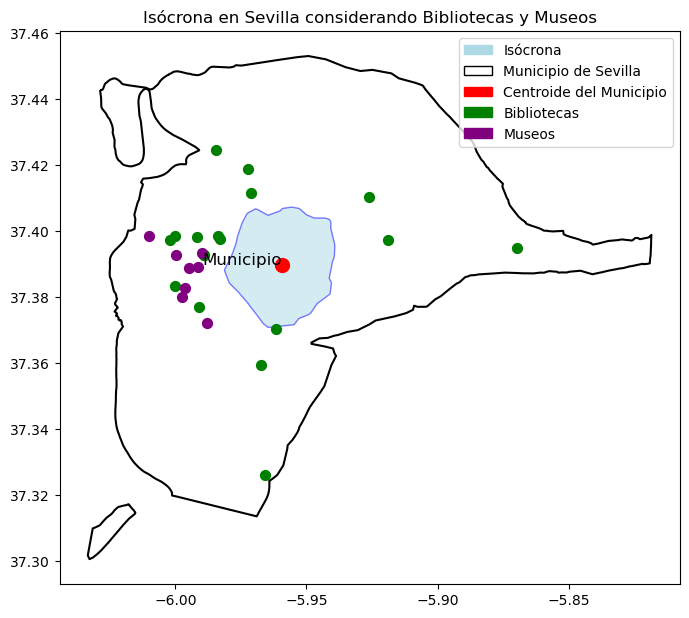

In [13]:
# 📌 PROBANDO CON UN MUNICIPIO (Sevilla)
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import shape, Point
import matplotlib.patches as mpatches

# 📌 Convertir la isócrona en un objeto geométrico
isocrona_geom = shape(isocrona)  # Convierte el JSON en una geometría de Shapely

# 📌 Crear un GeoDataFrame con la isócrona
isocrona_gdf = gpd.GeoDataFrame(geometry=[isocrona_geom], crs="EPSG:4326")

# 📌 Obtener la capa del municipio de Sevilla
municipio_sevilla = municipios_gdf[municipios_gdf["nombre"] == "Sevilla"]

# 📌 Obtener el centroide del municipio de Sevilla
centroide_sevilla = centroides_gdf.loc[centroides_gdf["nombre"] == "Sevilla", "centroide"].values[0]

# 📌 Obtener las bibliotecas y museos en Sevilla
bibliotecas_sevilla = bibliotecas_gdf[bibliotecas_gdf["municipio"] == "Sevilla"]
museos_sevilla = museos_gdf[museos_gdf["municipio"] == "Sevilla"]

# 📌 Crear un GeoDataFrame con el centroide
punto_municipio = gpd.GeoDataFrame({"nombre": ["Municipio de Sevilla"]}, geometry=[centroide_sevilla], crs="EPSG:4326")

# 📌 Graficar todas las capas
fig, ax = plt.subplots(figsize=(8, 8))

# 📌 Graficar el municipio de Sevilla
municipio_sevilla.plot(ax=ax, edgecolor="black", facecolor="none", linewidth=1.5)

# 📌 Graficar la isócrona
isocrona_gdf.plot(ax=ax, color="lightblue", edgecolor="blue", alpha=0.5)

# 📌 Graficar los puntos
punto_municipio.plot(ax=ax, color="red", markersize=100)
bibliotecas_sevilla.plot(ax=ax, color="green", markersize=50)
museos_sevilla.plot(ax=ax, color="purple", markersize=50)

# 📌 Etiqueta del centroide del municipio
ax.text(centroide_sevilla.x, centroide_sevilla.y, "Municipio", fontsize=12, ha="right", color="black")

# 📌 Crear leyenda manualmente
legend_patches = [
    mpatches.Patch(color="lightblue", label="Isócrona"),
    mpatches.Patch(edgecolor="black", facecolor="none", label="Municipio de Sevilla"),
    mpatches.Patch(color="red", label="Centroide del Municipio"),
    mpatches.Patch(color="green", label="Bibliotecas"),
    mpatches.Patch(color="purple", label="Museos")
]

plt.legend(handles=legend_patches, loc="upper right")

# 📌 Mostrar el mapa
plt.title("Isócrona en Sevilla considerando Bibliotecas y Museos")
plt.show()

Generando isócrona para Sevilla con tiempo máximo de 25 minutos...
Generando isócrona para Camas con tiempo máximo de 20 minutos...
Generando isócrona para Valencina de la Concepción con tiempo máximo de 15 minutos...


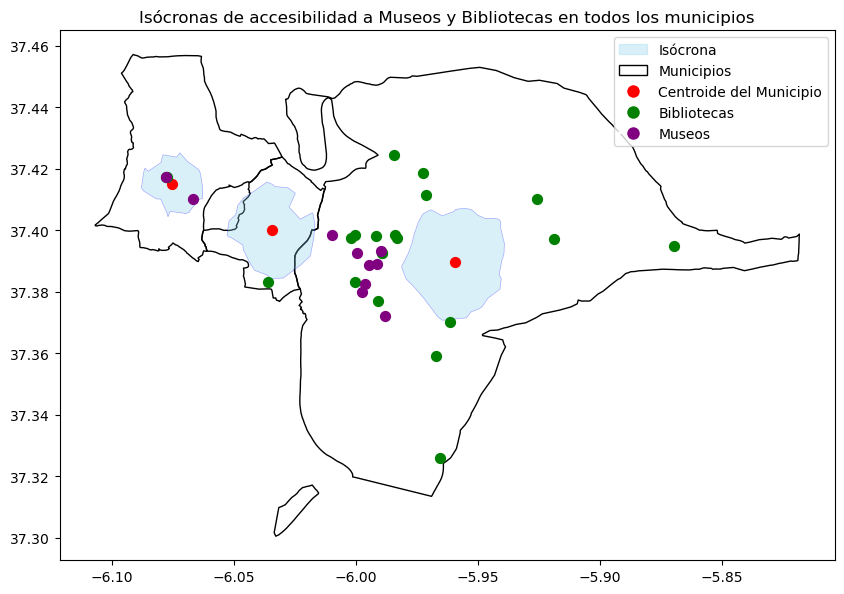

In [14]:
# 📌 Importar librerías
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
from shapely.geometry import Polygon

# 📌 Crear la figura y ejes
fig, ax = plt.subplots(figsize=(10, 8))

# 📌 Dibujar el contorno de todos los municipios
municipios_gdf.plot(ax=ax, edgecolor="black", facecolor="none", linewidth=1)

# 📌 Crear listas para la leyenda personalizada
handles = [
    mpatches.Patch(color="skyblue", alpha=0.3, label="Isócrona"),
    mpatches.Patch(edgecolor="black", facecolor="none", linewidth=1, label="Municipios"),
    plt.Line2D([0], [0], marker="o", color="w", markerfacecolor="red", markersize=10, label="Centroide del Municipio"),
    plt.Line2D([0], [0], marker="o", color="w", markerfacecolor="green", markersize=10, label="Bibliotecas"),
    plt.Line2D([0], [0], marker="o", color="w", markerfacecolor="purple", markersize=10, label="Museos"),
]

# 📌 Lista para almacenar todas las isócronas
isocronas_list = []

# 📌 Recorrer todos los municipios y calcular su isócrona
for i, row in centroides_gdf.iterrows():
    lat, lon = row["centroide"].y, row["centroide"].x
    tiempo_bibliotecas = int(row["tiempo_bibliotecas"])
    tiempo_museos = int(row["tiempo_museos"])
    
    # 📌 Obtener el tiempo máximo de viaje
    tiempo_maximo = max(tiempo_bibliotecas, tiempo_museos)

    print(f"Generando isócrona para {row['nombre']} con tiempo máximo de {tiempo_maximo} minutos...")
    
    # 📌 Obtener la isócrona
    isocrona = obtener_isocrona(lat, lon, tiempo_maximo)
    
    # 📌 Verificar si la API devolvió una isócrona válida
    if isocrona and "coordinates" in isocrona:
        # 📌 Convertir la isócrona en un GeoDataFrame
        polygon = Polygon(isocrona["coordinates"][0])  # Tomamos el primer polígono
        isocrona_gdf = gpd.GeoDataFrame(geometry=[polygon], crs="EPSG:4326")
        
        # 📌 Verificar si la conversión fue correcta
        if not isocrona_gdf.empty:
            isocrona_gdf.plot(ax=ax, facecolor="skyblue", alpha=0.3, edgecolor="blue", linewidth=0.5)
            isocronas_list.append(isocrona_gdf)  # 📌 Almacenar la isócrona en la lista
        else:
            print(f"⚠️ Advertencia: No se pudo convertir la isócrona en un GeoDataFrame para {row['nombre']}.")
    else:
        print(f"⚠️ Advertencia: La API no devolvió una isócrona válida para {row['nombre']}.")

    # 📌 Dibujar el centroide del municipio
    ax.scatter(lon, lat, color="red", s=50)

# 📌 Unir todas las isócronas en un único GeoDataFrame
if isocronas_list:
    isocronas_gdf = gpd.GeoDataFrame(pd.concat(isocronas_list, ignore_index=True), crs="EPSG:4326")
else:
    isocronas_gdf = gpd.GeoDataFrame(columns=["geometry"], crs="EPSG:4326")  # Evitar errores si está vacío

# 📌 Dibujar bibliotecas y museos
bibliotecas_gdf.plot(ax=ax, marker="o", color="green", linestyle="None", markersize=50)
museos_gdf.plot(ax=ax, marker="o", color="purple", linestyle="None", markersize=50)

# 📌 Configurar título y leyenda
plt.title("Isócronas de accesibilidad a Museos y Bibliotecas en todos los municipios")
ax.legend(handles=handles, loc="upper right")

plt.show()


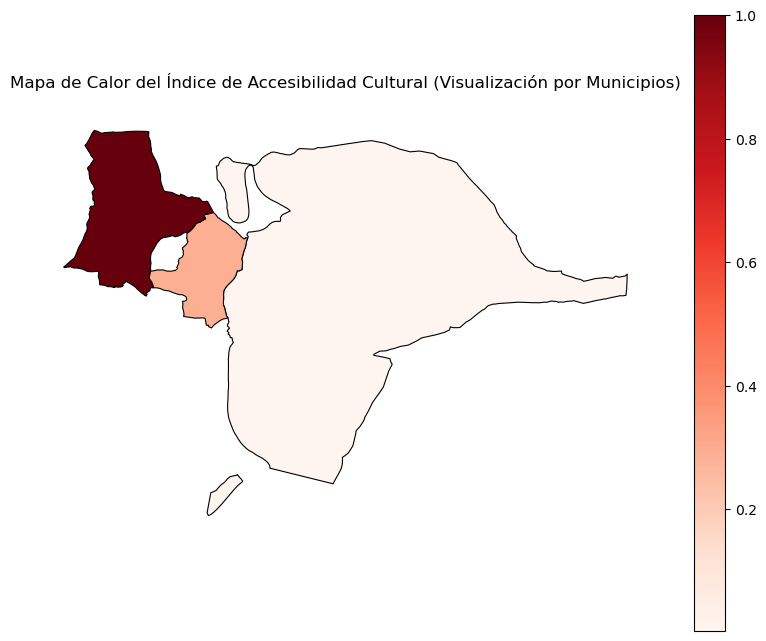

In [15]:
import geopandas as gpd
import matplotlib.pyplot as plt

# 📌 Asegurar que todo está en un CRS proyectado para cálculos de área correctos
nucleos_gdf = nucleos_gdf.to_crs(epsg=3857)
municipios_gdf = municipios_gdf.to_crs(epsg=3857)
isocronas_gdf = isocronas_gdf.to_crs(epsg=3857)

# 📌 Verificar que la columna 'poblacion' está en municipios_gdf
if "poblacion" not in municipios_gdf.columns:
    raise ValueError("La columna 'poblacion' no se encuentra en municipios_gdf.")

# 📌 Si ya existe la columna 'poblacion' en nucleos_gdf, eliminarla antes del merge
if "poblacion" in nucleos_gdf.columns:
    nucleos_gdf = nucleos_gdf.drop(columns=["poblacion"])

# 📌 Unir la población de municipios_gdf a nucleos_gdf según el nombre del municipio
nucleos_gdf = nucleos_gdf.merge(municipios_gdf[["nombre", "poblacion"]], on="nombre", how="left")

# 📌 Asegurar que la columna 'poblacion' ahora está en nucleos_gdf sin problemas
if "poblacion" not in nucleos_gdf.columns:
    raise ValueError("No se logró unir la población a nucleos_gdf.")

# 📌 Reemplazar valores NaN en 'poblacion' para evitar errores de división
nucleos_gdf["poblacion"] = nucleos_gdf["poblacion"].fillna(1)  # Evitar NaN
nucleos_gdf.loc[nucleos_gdf["poblacion"] == 0, "poblacion"] = 1  # Evitar divisiones por 0

# 📌 Calcular el área total de cada núcleo poblacional
nucleos_gdf["area_nucleo"] = nucleos_gdf.geometry.area

# 📌 Calcular el área de la isócrona dentro de cada núcleo
nucleos_gdf["area_isocrona"] = nucleos_gdf.apply(
    lambda row: isocronas_gdf.geometry.intersection(row.geometry).area.sum(), axis=1
)

# 📌 Calcular el Índice de Accesibilidad ponderado por población
nucleos_gdf["indice_accesibilidad"] = (nucleos_gdf["area_isocrona"] / nucleos_gdf["area_nucleo"]) / nucleos_gdf["poblacion"]

# 📌 Normalizar el índice (valores entre 0 y 1)
nucleos_gdf["indice_accesibilidad"] = nucleos_gdf["indice_accesibilidad"] / nucleos_gdf["indice_accesibilidad"].max()

# 📌 Asignar el índice de accesibilidad del núcleo a su municipio correspondiente
municipios_gdf = municipios_gdf.merge(nucleos_gdf[["nombre", "indice_accesibilidad"]], on="nombre", how="left")

# 📌 Crear el heatmap del Índice de Accesibilidad en municipios
fig, ax = plt.subplots(figsize=(10, 8))

# 📌 Dibujar municipios coloreados según accesibilidad
municipios_gdf.plot(column="indice_accesibilidad", cmap="Reds", linewidth=0.8, edgecolor="black", legend=True, ax=ax)

# 📌 Agregar título y ocultar ejes
plt.title("Mapa de Calor del Índice de Accesibilidad Cultural (Visualización por Municipios)")
plt.axis("off")

plt.show()


In [16]:
import pandas as pd
from tabulate import tabulate

# 📌 Crear DataFrame con valores estéticos
tabla_df = municipios_gdf[["nombre", "indice_accesibilidad"]].sort_values(by="indice_accesibilidad", ascending=False)

# 📌 Convertir valores a formato más legible
tabla_df["indice_accesibilidad"] = tabla_df["indice_accesibilidad"].apply(lambda x: f"{x:.3f}")

# 📌 Mostrar la tabla formateada
print(tabulate(tabla_df, headers="keys", tablefmt="fancy_grid", showindex=False))

╒════════════════════════════╤════════════════════════╕
│ nombre                     │   indice_accesibilidad │
╞════════════════════════════╪════════════════════════╡
│ Valencina de la Concepción │                  1     │
├────────────────────────────┼────────────────────────┤
│ Camas                      │                  0.288 │
├────────────────────────────┼────────────────────────┤
│ Sevilla                    │                  0.003 │
╘════════════════════════════╧════════════════════════╛
